# Определение токсичных комментариев для интернет-сервиса магазина

**Описание проекта**

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные

**Описание данных**

* `text` - текст комментария
* `toxic` - целевой признак

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

RANDOM_STATE = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gturk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gturk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gturk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gturk\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [30]:
data = pd.read_csv('toxic_comments.csv')
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [31]:
data = data.drop(['Unnamed: 0'], axis=1)

In [32]:
# Очистка текста от ненужных символов, токенизация и лемматизация
def prepare_text(text):
    txt = text.lower()
    txt = re.sub(r'[^a-zA-Z]', ' ', txt)
    txt = ' '.join(txt.split())
    
    tokenized = word_tokenize(txt)
    
    wnl = WordNetLemmatizer()
    
    lemm_list = [wnl.lemmatize(word) for word in tokenized]
    lemm_text = ' '.join(lemm_list)
    
    return lemm_text

In [33]:
# Очистка текста и создание корпуса
corpus = data['text'].apply(lambda x: prepare_text(x))

In [34]:
corpus.head()

0    explanation why the edits made under my userna...
1    d aww he match this background colour i m seem...
2    hey man i m really not trying to edit war it s...
3    more i can t make any real suggestion on impro...
4    you sir are my hero any chance you remember wh...
Name: text, dtype: object

In [35]:
corpus.shape

(159292,)

In [36]:
# Создание списка стоп-слов
stop_words = stopwords.words('english')

In [37]:
# Деление на тренировочную, валидационную и тестовую выборки в соотношении 3:1
X_train, X_test, y_train, y_test = train_test_split(corpus, data['toxic'], test_size=0.25, stratify=data['toxic'], random_state=RANDOM_STATE)

In [38]:
X_train.shape

(119469,)

In [39]:
X_train.head()

119339    it is obvious you do not give a crap about act...
116426    note also that the policy doe not say to avoid...
56586     he ha shown u the connection between aa and b ...
61960     bias why is this nutcase changing my truthful ...
64264     sysiq page edits hasteur thank you for reminde...
Name: text, dtype: object

In [41]:
X_test.head()

124823    self promotion is it then there is no jacobite...
56809     here s an article but i m sure a better source...
123275    utc why not ahmadinejad ha been accused of ant...
64673     what for thing i didnt vandelize stop talkin t...
123056    january utc agree with coltsfan nobody is sayi...
Name: text, dtype: object

In [42]:
y_train.shape, y_test.shape

((119469,), (39823,))

In [44]:
# Применение TF-IDF
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
train_tf_idf = count_tf_idf.fit_transform(X_train)
test_tf_idf = count_tf_idf.transform(X_test)

## Работа с моделями машинного обучения

### Изучение баланса классов

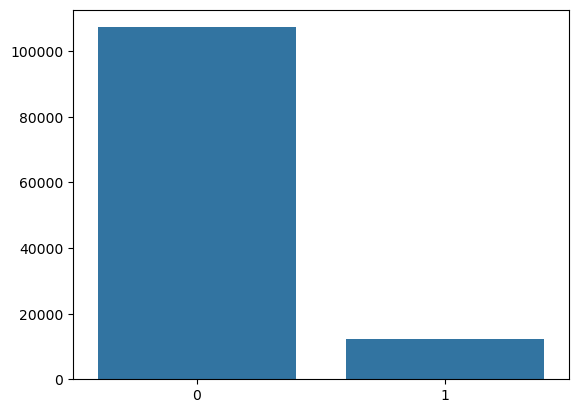

In [45]:
sns.barplot(x=[0, 1], y=[list(y_train).count(0), list(y_train).count(1)]);

In [46]:
y_train.value_counts(normalize=True)

toxic
0    0.898384
1    0.101616
Name: proportion, dtype: float64

Данные явно не сбалансированы. Попробуем два варианта: обучение на несбалансированных данных и учет дисбаланса классов с помощью указания `class_weight='balanced'`

#### Базовая модель - DummyClassifier

In [47]:
dummy = DummyClassifier()
dummy.fit(train_tf_idf, y_train)
dummy_pred = dummy.predict(valid_tf_idf)
print(f'F1-score: {f1_score(y_valid, dummy_pred) : .2f}')

F1-score:  0.00


### Без учета дисбаланса

#### LogisticRegression

In [49]:
log_reg = LogisticRegression(max_iter=500, random_state=RANDOM_STATE, n_jobs=-1)

params = {
    'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
}

clf = GridSearchCV(log_reg, params, scoring='f1', cv=5)
clf.fit(train_tf_idf, y_train)
print(f'Best params: {clf.best_params_}, best F1-score: {clf.best_score_}')

Best params: {'C': 1}, best F1-score: 0.7120089079006348


#### DecisionTreeClassifier

In [50]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

params = {
    'max_depth': list(range(4, 10))
}

clf = GridSearchCV(tree, params, scoring='f1', cv=5, n_jobs=-1)
clf.fit(train_tf_idf, y_train)
print(f'Best params: {clf.best_params_}, best F1-score: {clf.best_score_}')

Best params: {'max_depth': 9}, best F1-score: 0.5741724584307571


#### RandomForestClassifier

In [51]:
rf = RandomForestClassifier(random_state=RANDOM_STATE)

params = {
    'n_estimators': list(range(30, 151, 30)),
    'max_depth': list(range(4, 10))
}

clf = GridSearchCV(rf, params, scoring='f1', cv=5, n_jobs=-1)
clf.fit(train_tf_idf, y_train)
print(f'Best params: {clf.best_params_}, best F1-score: {clf.best_score_}')

Best params: {'max_depth': 4, 'n_estimators': 30}, best F1-score: 0.0


#### LGBMClassifier

In [52]:
lgb = LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1)

params = {
    'n_estimators': list(range(20, 201, 20))
}

clf = GridSearchCV(lgb, params, scoring='f1', cv=5, n_jobs=-1)
clf.fit(train_tf_idf, y_train)
print(f'Best params: {clf.best_params_}, best F1-score: {clf.best_score_}')

Best params: {'n_estimators': 200}, best F1-score: 0.7616907888178417


### Учет дисбаланса классов

#### LogisticRegression

In [53]:
log_reg = LogisticRegression(max_iter=500, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)

params = {
    'C': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
}

clf = GridSearchCV(log_reg, params, scoring='f1', cv=5)
clf.fit(train_tf_idf, y_train)
print(f'Best params: {clf.best_params_}, best F1-score: {clf.best_score_}')

Best params: {'C': 1}, best F1-score: 0.7484213990920322


#### DecisionTreeClassifier

In [54]:
tree = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)

params = {
    'max_depth': list(range(4, 10))
}

clf = GridSearchCV(tree, params, scoring='f1', cv=5, n_jobs=-1)
clf.fit(train_tf_idf, y_train)
print(f'Best params: {clf.best_params_}, best F1-score: {clf.best_score_}')

Best params: {'max_depth': 9}, best F1-score: 0.5468974881398558


#### RandomForestClassifier

In [55]:
rf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

params = {
    'n_estimators': list(range(30, 151, 30)),
    'max_depth': list(range(4, 10))
}

clf = GridSearchCV(rf, params, scoring='f1', cv=5, n_jobs=-1)
clf.fit(train_tf_idf, y_train)
print(f'Best params: {clf.best_params_}, best F1-score: {clf.best_score_}')

Best params: {'max_depth': 9, 'n_estimators': 150}, best F1-score: 0.35370786783618374


#### LGBMClassifier

In [56]:
lgb = LGBMClassifier(class_weight='balanced', random_state=RANDOM_STATE, verbosity=-1)

params = {
    'n_estimators': list(range(40, 201, 40))
}

clf = GridSearchCV(lgb, params, scoring='f1', cv=5, n_jobs=-1)
clf.fit(train_tf_idf, y_train)
print(f'Best params: {clf.best_params_}, best F1-score: {clf.best_score_}')

Best params: {'n_estimators': 200}, best F1-score: 0.7465906985589795


#### Вывод

В ходе исследования были перепробованы различные модели: логистическая регрессия, деревья решений, случайный лес и бустинг в реализации lightgbm. Лучший результат показала модель логистической регрессии, учитывавшая дисбаланс классов. Ее возьмем для проведения итогового тестирования

### Итоговое тестирование

In [57]:
model = LogisticRegression(C=1, max_iter=500, random_state=RANDOM_STATE, class_weight='balanced')
model.fit(train_tf_idf, y_train)
pred = model.predict(test_tf_idf)
print('F1-score:', f1_score(y_test, pred))

F1-score: 0.7441758722519961


По итогам тестирования логистическая регрессия показала результат, сравнимый с полученным на кросс-валидации.

### Итоговый вывод

* В ходе исследования были изучены разные модели машинного обучения, начиная от `LogisticRegression` и кончая `LGBMClassifier`

* Обучение моделей проводилось двумя способами: без учета дисбаланса классов и с учетом этого дисбаланса

* Лучший результат показала логистическая регрессия, обученная с учетом дисбаланса классов

* Результаты итогового тестирования лучшей модели:
  
    * параметры: `C=1, max_iter=500, random_state=42, class_weight='balanced'`
    
    * F1-score: 0.74